In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications.densenet import DenseNet169, DenseNet201, DenseNet121
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import losses, optimizers, activations, metrics

In [0]:
import tensorflow_datasets as tfds
pcam, pcam_info = tfds.load("patch_camelyon", download=False ,shuffle_files=False, with_info=True,data_dir='/content/drive/My Drive/Colab Notebooks')
print(pcam_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018

In [0]:
'''densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    #model.add(Dense(2, activation = "softmax"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=SGD(lr=0.001),
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.summary()'''   
#Test set accuracy is 0.8098 obtained

'densenet = DenseNet121(\n    weights=\'imagenet\',\n    include_top=False,\n    input_shape=(96,96,3)\n)\ndef build_model():\n    model = Sequential()\n    model.add(densenet)\n    model.add(GlobalAveragePooling2D())\n    #model.add(Dropout(0.5))\n    model.add(Dense(512, activation=\'relu\'))\n    model.add(Dense(2, activation=\'sigmoid\'))\n    #model.add(Dense(2, activation = "softmax"))\n    \n    model.compile(\n        loss=\'binary_crossentropy\',\n        optimizer=SGD(lr=0.001),\n        metrics=[\'accuracy\']\n    )\n    \n    return model\n\nmodel = build_model()\nmodel.summary()'

In [0]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
densenet.trainable = False
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(2, activation = "softmax"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='SGD',
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________

In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(128).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [0]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=30, steps_per_epoch=512, validation_steps=256)

Epoch 1/30
512/512 - 82s - loss: 0.5538 - accuracy: 0.7327 - val_loss: 0.4262 - val_accuracy: 0.8022
Epoch 2/30
512/512 - 57s - loss: 0.4423 - accuracy: 0.7964 - val_loss: 0.4055 - val_accuracy: 0.8103
Epoch 3/30
512/512 - 57s - loss: 0.4120 - accuracy: 0.8160 - val_loss: 0.3996 - val_accuracy: 0.8118
Epoch 4/30
512/512 - 58s - loss: 0.3948 - accuracy: 0.8236 - val_loss: 0.3953 - val_accuracy: 0.8135
Epoch 5/30
512/512 - 60s - loss: 0.3887 - accuracy: 0.8264 - val_loss: 0.3945 - val_accuracy: 0.8138
Epoch 6/30
512/512 - 57s - loss: 0.3766 - accuracy: 0.8341 - val_loss: 0.3952 - val_accuracy: 0.8110
Epoch 7/30
512/512 - 56s - loss: 0.3691 - accuracy: 0.8383 - val_loss: 0.3876 - val_accuracy: 0.8179
Epoch 8/30
512/512 - 56s - loss: 0.3640 - accuracy: 0.8398 - val_loss: 0.3854 - val_accuracy: 0.8177
Epoch 9/30
512/512 - 57s - loss: 0.3644 - accuracy: 0.8416 - val_loss: 0.3900 - val_accuracy: 0.8139
Epoch 10/30
512/512 - 64s - loss: 0.3554 - accuracy: 0.8439 - val_loss: 0.3839 - val_accura

In [0]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Test set accuracy is 0.8193


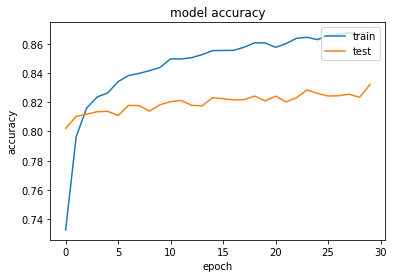

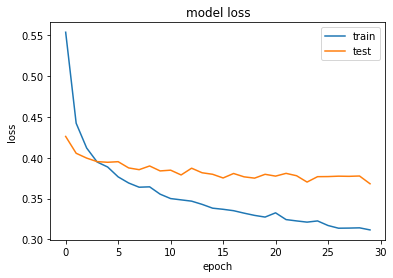

In [0]:
hist2=hist
plt.figure()
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


[0 1 0 ... 1 1 0]


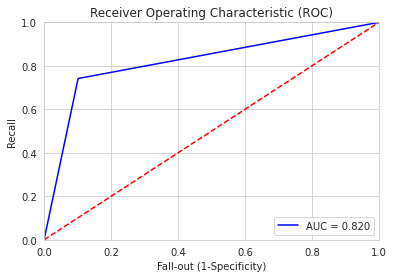

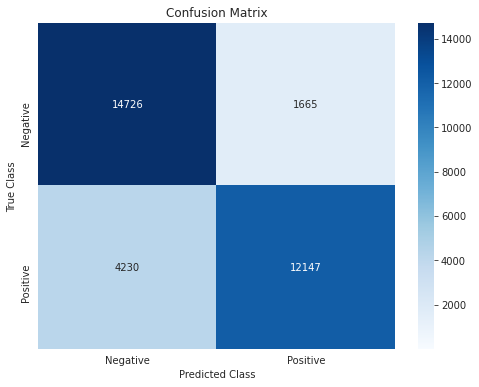

In [0]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Predict on test set
predictions_NN_prob = model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 0,1) #Turn probability to 0-1 binary output

#Print Area Under Curve
y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])
print(test_y)
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_01)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative','Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

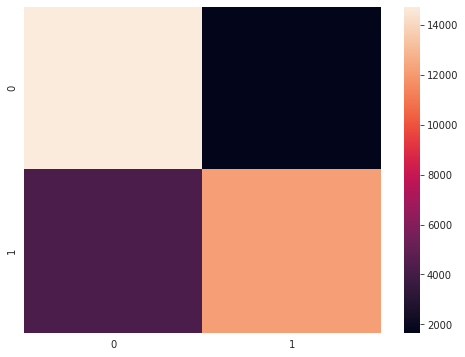

In [0]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
plt.figure(figsize=(8,6))
sns.heatmap(cm);

plt.show()